In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# from matplotlib import style
# style.use('seaborn-whitegrid')


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# Show table names, columns, and data types
for table in Base.classes:
    print(f"Table name: {table.__table__.name}")
    for c in table.__table__.columns:
        print(f"   {c.name} {c.type}", end='')
        if c.primary_key:
            print("  PRIMARY KEY")
        else:
            print()

Table name: measurement
   id INTEGER  PRIMARY KEY
   station TEXT
   date TEXT
   prcp FLOAT
   tobs FLOAT
Table name: station
   id INTEGER  PRIMARY KEY
   station TEXT
   name TEXT
   latitude FLOAT
   longitude FLOAT
   elevation FLOAT


In [8]:
# Save references to each table
Meas = Base.classes.measurement
Sta = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

# Exploratory Climate Analysis

In [12]:

sel = [Meas.station, 
       func.min(Meas.date), 
       func.max(Meas.date),
       func.count(Meas.date)]
sta_daterange = session.query(*sel).\
    group_by(Meas.station).\
    order_by(Meas.station).all()
cols = ['Station','Start_date','End_date', 'Obs_count']
df_sta_dates = pd.DataFrame(sta_daterange, columns=cols)
df_sta_dates['Start_date'] = pd.to_datetime(df_sta_dates['Start_date'])
df_sta_dates['End_date'] = pd.to_datetime(df_sta_dates['End_date'])
df_sta_dates['Date_diff'] = (df_sta_dates['End_date'] - df_sta_dates['Start_date']).dt.days + 1
df_sta_dates['Pcnt_complete'] = round(df_sta_dates['Obs_count'] / df_sta_dates['Date_diff'] * 100, 2)
df_sta_dates.set_index('Station')

,Start_date,End_date,Obs_count,Date_diff,Pcnt_complete
Station,,,,,
USC00511918,2010-01-01,2015-10-30,1979,2129,92.95
USC00513117,2010-01-01,2017-07-31,2709,2769,97.83
USC00514830,2010-03-01,2017-08-23,2202,2733,80.57
USC00516128,2010-01-01,2017-08-23,2612,2792,93.55
USC00517948,2010-05-03,2017-07-31,1372,2647,51.83
USC00518838,2010-01-01,2015-11-20,511,2150,23.77
USC00519281,2010-01-01,2017-08-18,2772,2787,99.46
USC00519397,2010-01-01,2017-08-23,2724,2792,97.56
USC00519523,2010-01-01,2017-08-23,2669,2792,95.59


In [13]:
# Show Period of Record for each station
sel = [Meas.station,
       func.min(Meas.date), 
       func.max(Meas.date),
       Sta.name]
sta_daterange = session.query(*sel).\
    filter(Meas.station == Sta.station).\
    group_by(Meas.station).\
    order_by(Sta.name).all()
sta_daterange

[('USC00511918', '2010-01-01', '2015-10-30', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00513117', '2010-01-01', '2017-07-31', 'KANEOHE 838.1, HI US'),
 ('USC00514830', '2010-03-01', '2017-08-23', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00516128', '2010-01-01', '2017-08-23', 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00517948', '2010-05-03', '2017-07-31', 'PEARL CITY, HI US'),
 ('USC00518838', '2010-01-01', '2015-11-20', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519281', '2010-01-01', '2017-08-18', 'WAIHEE 837.5, HI US'),
 ('USC00519397', '2010-01-01', '2017-08-23', 'WAIKIKI 717.2, HI US'),
 ('USC00519523', '2010-01-01', '2017-08-23', 'WAIMANALO EXPERIMENTAL FARM, HI US')]

### Plot 12 months of precipitation data

In [14]:
# Retrieve 12 months of precipitation data spanning 2016-08-01 through 2017-07-31
sel = [Meas.station,
       Meas.date,
       Meas.prcp]

enddate = dt.date.fromisoformat('2017-07-31')
startdate = enddate - dt.timedelta(days=364)
print(startdate)

sta_prcp = session.query(*sel).\
    filter(Meas.date >= startdate).\
    filter(Meas.date <= enddate).all()

for row in sta_prcp[0:10]:
    print(row)
print(f"\nRecord count: {len(sta_prcp)}")

2016-08-01
('USC00519397', '2016-08-01', 0.08)
('USC00519397', '2016-08-02', 0.05)
('USC00519397', '2016-08-03', 0.0)
('USC00519397', '2016-08-04', 0.04)
('USC00519397', '2016-08-05', 0.01)
('USC00519397', '2016-08-06', 0.0)
('USC00519397', '2016-08-07', 0.39)
('USC00519397', '2016-08-08', 0.02)
('USC00519397', '2016-08-09', 0.0)
('USC00519397', '2016-08-10', 0.0)

Record count: 2281


In [15]:
# Save the query results as a Pandas DataFrame
cols = ['Sta_ID', 'Date', 'Prec']
df_sta_prcp = pd.DataFrame(sta_prcp, columns=cols)
df_sta_prcp['Coop_ID'] = df_sta_prcp['Sta_ID'].str[-6:]
df_sta_prcp.drop(columns=['Sta_ID'], inplace=True)
display(df_sta_prcp.head(5))

# Show count of NaN values for Prec
display(df_sta_prcp['Prec'].isna().sum())

# Get list of unique stations
sta_prcp_list = sorted(list(df_sta_prcp['Coop_ID'].unique()))
display(sta_prcp_list)

df_prcp = pd.pivot_table(df_sta_prcp, values='Prec', index='Date', columns='Coop_ID', aggfunc='first')


# df_prcp = df_prcp.rename_axis(None, axis=1)
df_prcp.index = pd.to_datetime(df_prcp.index)
display(df_prcp.head(5))

display(df_prcp.index.dtype)
display(df_prcp.count())
df_prcp.sum()



,Date,Prec,Coop_ID
0,2016-08-01,0.08,519397
1,2016-08-02,0.05,519397
2,2016-08-03,0.00,519397
3,2016-08-04,0.04,519397
4,2016-08-05,0.01,519397


214

['513117', '514830', '516128', '517948', '519281', '519397', '519523']

Coop_ID,513117,514830,516128,517948,519281,519397,519523
Date,,,,,,,
2016-08-01,2.35,NaN,2.21,NaN,3.53,0.08,0.54
2016-08-02,0.20,0.55,1.14,0.00,0.83,0.05,0.07
2016-08-03,0.02,0.00,NaN,0.02,0.01,0.00,0.00
2016-08-04,0.62,NaN,NaN,0.13,0.77,0.04,0.25
2016-08-05,0.03,NaN,NaN,0.03,0.27,0.01,0.00


dtype('<M8[ns]')

Coop_ID
513117    365
514830    260
516128    331
517948     67
519281    365
519397    360
519523    319
dtype: int64

Coop_ID
513117     54.39
514830     34.14
516128    157.91
517948      4.77
519281     79.49
519397     17.18
519523     39.80
dtype: float64

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

# Discard Coop_ID 517948 since it has limited data
df_prcp.drop(columns='517948', inplace=True)


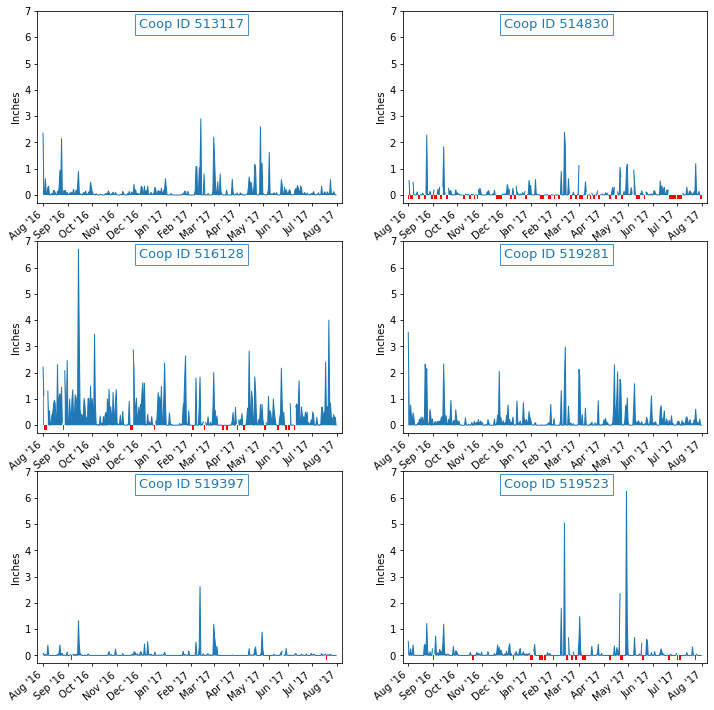

In [18]:

dates = df_prcp.index
xmin = startdate - dt.timedelta(days=7)
xmax = enddate + dt.timedelta(days=7)


axs = plt.figure(figsize=(12,12)).subplots(3,2)
plt.setp(axs, ylim=([-0.3,7]), xlim=([xmin,xmax]), ylabel='Inches')
bbox_props = dict(boxstyle="square", fc="w", ec='tab:blue', alpha=0.8)
axs = axs.flat

for ax,station in zip(axs, df_prcp.columns):
    prec = df_prcp[station].values
    NaNs = [-0.17 if np.isnan(x) else np.nan for x in prec]
    ax.plot(dates, prec, linewidth=1)                                   # width=pd.Timedelta(days=1)
    ax.fill_between(dates, df_prcp[station])
    ax.bar(dates, NaNs, color='red', width=pd.Timedelta(days=1))
    ax.text(dt.datetime(2017,2,1), 6.5, 'Coop ID '+station, color='tab:blue', ha="center", va="center", size=13, bbox=bbox_props)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    for label in ax.get_xticklabels():
        label.set_rotation(40)
        label.set_horizontalalignment('right')    
    ax.tick_params(axis='both', length=3)


# plt.savefig('prec_plots.png', dpi=300)

In [60]:
df_prcp.describe()

Coop_ID,513117,514830,516128,519281,519397,519523
count,365.000000,260.000000,331.000000,365.000000,360.000000,319.000000
mean,0.149014,0.131308,0.477069,0.217781,0.047722,0.124765
std,0.354761,0.320596,0.732042,0.462878,0.190305,0.506417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
50%,0.030000,0.020000,0.220000,0.060000,0.000000,0.000000
75%,0.130000,0.120000,0.700000,0.200000,0.020000,0.070000
max,2.900000,2.390000,6.700000,3.530000,2.620000,6.250000


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
